# DA5401 A6: Imputation via Regression for Missing Data
## Objective: 

This assignment challenges you to apply linear and non-linear regression to impute
missing values in a dataset. The effectiveness of your imputation methods will be measured
indirectly by assessing the performance of a subsequent classification task, comparing the
regression-based approach against simpler imputation strategies.

## 1. Problem Statement
You are a machine learning engineer working on a credit risk assessment project. You have
been provided with the UCI Credit Card Default Clients Dataset. This dataset has missing
values in several important feature columns. The presence of missing data prevents the
immediate application of many classification algorithms.
Your task is to implement three different strategies for handling the missing data and then use
the resulting clean datasets to train and evaluate a classification model. This will demonstrate
how the choice of imputation technique significantly impacts final model performance.
You will submit a Jupyter Notebook with your complete code, visualizations, and a plausible
story that explains your findings. The notebook should be well-commented, reproducible, and
easy to follow.
### Dataset:
- UCI Credit Card Default Clients Dataset (with missing values): Kaggle - Credit Card
Default Clients Dataset (https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset)
    - Note: While the original UCI dataset is relatively clean, for this assignment, you
should artificially introduce Missing At Random (MAR) values (e.g., replace
5% of the values in the 'AGE' and 'BILL_AMT' columns with NaN) before starting
Part A, to simulate a real-world scenario with a substantial missing data problem.

## 2. Tasks
### Part A: Data Preprocessing and Imputation

In [41]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd



In [25]:
df = pd.read_csv('/Users/navaneethakrishnan/Desktop/DAL/assignment_6_Navaneeth272001/UCI_Credit_Card.csv')  # change path by pasting the file path
print("Initial shape:", df.shape)
print(df[['AGE', 'BILL_AMT1', 'PAY_AMT3']].describe())

df_mar = df.copy() #Create a copy for MAR missingness injection

np.random.seed(42)

# Compute conditional subsets (for MAR logic)
cond_bill = df_mar['AGE'] > 50          # BILL_AMT1 depends on AGE
cond_age = df_mar['EDUCATION'] == 1     # AGE depends on EDUCATION
cond_pay = df_mar['MARRIAGE'] == 2      # PAY_AMT3 depends on MARRIAGE status

# Calculate fractions needed for ~5% overall missing per feature
frac_bill = 0.05 / cond_bill.mean()
frac_age = 0.05 / cond_age.mean()
frac_pay = 0.05 / cond_pay.mean()

# Apply MAR missingness scaled to achieve approx 5% total for each column
mask_mar_bill = cond_bill & (np.random.rand(len(df_mar)) < frac_bill)
mask_mar_age = cond_age & (np.random.rand(len(df_mar)) < frac_age)
mask_mar_pay = cond_pay & (np.random.rand(len(df_mar)) < frac_pay)

df_mar.loc[mask_mar_bill, 'BILL_AMT1'] = np.nan
df_mar.loc[mask_mar_age, 'AGE'] = np.nan
df_mar.loc[mask_mar_pay, 'PAY_AMT3'] = np.nan

# Check result again
missing_summary = df_mar[['AGE', 'BILL_AMT1', 'PAY_AMT3']].isna().mean() * 100
print("\nAdjusted missing percentage after MAR injection (df_mar):")
print(missing_summary.round(2))

target_col = "default.payment.next.month" # Define target column
y = df_mar[target_col] # Create target variable
X = df_mar.drop(columns=[target_col]) # Create feature matrix by dropping the target column

print("\nFeature matrix and target vector created successfully (from df_mar).")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("\nTarget variable distribution:")
print(y.value_counts(normalize=True).round(3))


Initial shape: (30000, 25)
                AGE      BILL_AMT1      PAY_AMT3
count  30000.000000   30000.000000   30000.00000
mean      35.485500   51223.330900    5225.68150
std        9.217904   73635.860576   17606.96147
min       21.000000 -165580.000000       0.00000
25%       28.000000    3558.750000     390.00000
50%       34.000000   22381.500000    1800.00000
75%       41.000000   67091.000000    4505.00000
max       79.000000  964511.000000  896040.00000

Adjusted missing percentage after MAR injection (df_mar):
AGE          5.03
BILL_AMT1    4.99
PAY_AMT3     5.00
dtype: float64

Feature matrix and target vector created successfully (from df_mar).
X shape: (30000, 24)
y shape: (30000,)

Target variable distribution:
default.payment.next.month
0    0.779
1    0.221
Name: proportion, dtype: float64


In [29]:
# 2. Imputation Strategy 1: Simple Imputation (Baseline):

#Create a clean dataset copy (Dataset A). For each column with missing values, fill the missing values with the median of that column. 

df_clean = df_mar.copy()
missing_cols = df_clean.columns[df_clean.isna().any()]
print("\nColumns with missing values:", list(missing_cols))

# Fill missing values with column median (Dataset A)
df_A = df_clean.copy()
for col in missing_cols:
    median_value = df_A[col].median()
    df_A[col] = df_A[col].fillna(median_value)

print("\nMissing values after median imputation:")
print(df_A[missing_cols].isna().sum())
print("\nShape of Dataset A:", df_A.shape)
print(df_A[['AGE', 'BILL_AMT1']].describe())



Columns with missing values: ['AGE', 'BILL_AMT1', 'PAY_AMT3']

Missing values after median imputation:
AGE          0
BILL_AMT1    0
PAY_AMT3     0
dtype: int64

Shape of Dataset A: (30000, 25)
                AGE      BILL_AMT1
count  30000.000000   30000.000000
mean      35.483300   49635.322700
std        9.034407   71505.228811
min       21.000000 -165580.000000
25%       28.000000    4150.250000
50%       34.000000   22399.000000
75%       41.000000   62774.250000
max       79.000000  964511.000000


Explain why the median is often preferred over the mean for imputation.

- Robustness to Outliers
    - The mean is sensitive to extreme values (outliers).
    - The median, on the other hand, is not affected by outliers, it only depends on the middle value of the sorted data.
    - So it provides a more stable and representative imputation value when the data are skewed or contain outliers.
- Better for Skewed Distributions
    - Many real-world variables (for example income, bill amounts, age) are right-skewed — meaning there are a few very large values.
    - The mean in such cases doesn’t represent the “typical” observation, but the median does.
    - Median imputation preserves the central tendency better for non-normal (skewed) distributions.
- Preserves Rank and Spread Better
    - When we impute using the mean, we might flatten variability and distort the data’s distribution.
    - Using the median preserves relative ordering and the shape of the distribution more faithfully.
- Simplicity and Interpretability
    - Median imputation is simple, quick, and computationally efficient.
    - It doesn’t require complex modeling assumptions, it just replaces missing values with a robust measure of central tendency.

In [27]:
#Creating a dataset copy with one of column with nul value for training models
df_mar_1 = df.copy()

np.random.seed(42)

cond_bill = df_mar_1['AGE'] > 50
frac_bill = 0.05 / cond_bill.mean()
mask_mar_bill = cond_bill & (np.random.rand(len(df_mar_1)) < frac_bill)
df_mar_1.loc[mask_mar_bill, 'BILL_AMT1'] = np.nan
missing_summary = df_mar_1[['BILL_AMT1']].isna().mean() * 100
print("\nAdjusted missing percentage after MAR injection (df_mar):")
print(missing_summary.round(2))
target_col = "default.payment.next.month"
y = df_mar_1[target_col]
X = df_mar_1.drop(columns=[target_col])

print("\nFeature matrix and target vector created successfully (from df_mar).")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("\nTarget variable distribution:")
print(y.value_counts(normalize=True).round(3))



Adjusted missing percentage after MAR injection (df_mar):
BILL_AMT1    4.99
dtype: float64

Feature matrix and target vector created successfully (from df_mar).
X shape: (30000, 24)
y shape: (30000,)

Target variable distribution:
default.payment.next.month
0    0.779
1    0.221
Name: proportion, dtype: float64


In [ ]:
#3. Imputation Strategy 2: Regression Imputation (Linear):

#Create a second clean dataset copy (Dataset B). For a single column (your choice) with missing values, use a Linear Regression model to predict the missing values based on all other non-missing features.


# Make a fresh copy
df_B = df_mar_1.copy()

# Choose the column with missing values (example: 'BILL_AMT1')
target_col_missing = 'BILL_AMT1'

# Split data into rows with and without missing target values
df_not_missing = df_B[df_B[target_col_missing].notna()]
df_missing = df_B[df_B[target_col_missing].isna()]

print(f"\nNumber of missing rows in '{target_col_missing}': {len(df_missing)}")

# Define features (all other columns) and target
X_train = df_not_missing.drop(columns=[target_col_missing])
y_train = df_not_missing[target_col_missing]

# Prepare rows where target_col_missing is NaN
X_pred = df_missing.drop(columns=[target_col_missing])

# Fill remaining missing numeric values (excluding the target column) with medians
X_train = X_train.fillna(X_train.median())
X_pred = X_pred.fillna(X_pred.median())

# Fit Linear Regression model on all available (non-missing) data
reg = LinearRegression()
reg.fit(X_train, y_train)

# Predict missing BILL_AMT1 values
predicted_values = reg.predict(X_pred)

# Replace missing values with predicted values
df_B.loc[df_B[target_col_missing].isna(), target_col_missing] = predicted_values

# Verify the imputation
print("\nMissing values after Linear Regression imputation:")
print(df_B[target_col_missing].isna().sum())

print("\nShape of Dataset B:", df_B.shape)
print(df_B[[target_col_missing]].describe())



Number of missing rows in 'BILL_AMT1': 1497

Missing values after Linear Regression imputation:
0

Shape of Dataset B: (30000, 25)
           BILL_AMT1
count   30000.000000
mean    51234.990466
std     73384.517925
min   -165580.000000
25%      3933.000000
50%     22458.988339
75%     66979.750000
max    964511.000000


Explain the underlying assumption of this method (Missing At Random).

- Missing At Random (MAR) Definition:
    - Missingness of a variable depends on other observed variables, but not on the value of the variable itself.
    - Mathematically:
        - P(missing in X_miss | X_miss, X_obs) = P(missing in X_miss | X_obs)
- How it relates to Linear Regression Imputation:
    - Missing values can be predicted using correlations with observed features.
    - Works well under MAR because missingness is systematically related to other variables, not the missing values themselves.
    - Regression predicts the conditional mean of the missing values given observed variables.


In [ ]:
# 4. Imputation Strategy 3: Regression Imputation (Non-Linear):

#Create a third clean dataset copy (Dataset C). For the same column as in Strategy 2, use a non-linear regression model (e.g., K-Nearest Neighbors Regression or Decision Tree Regression) to predict the missing values.

df_C = df_mar_1.copy()
target_col_missing = 'BILL_AMT1' # Column with missing values

# Split data into rows with and without missing target values
df_not_missing = df_C[df_C[target_col_missing].notna()]
df_missing = df_C[df_C[target_col_missing].isna()]

print(f"\nNumber of missing rows in '{target_col_missing}': {len(df_missing)}")

# Define features (all other columns) and target
X_train = df_not_missing.drop(columns=[target_col_missing])
y_train = df_not_missing[target_col_missing]
X_pred = df_missing.drop(columns=[target_col_missing]) # Prepare rows where target_col_missing is NaN

# Fill remaining missing numeric values (excluding the target column) with medians
X_train = X_train.fillna(X_train.median())
X_pred = X_pred.fillna(X_pred.median())

# Option 1: K-Nearest Neighbors Regressor
model = KNeighborsRegressor(n_neighbors=5)

# Option 2: Decision Tree Regressor (uncomment the next line to use it instead)
# model = DecisionTreeRegressor(max_depth=10, random_state=42)

# Fit model on all available (non-missing) data
model.fit(X_train, y_train)

# Predict missing BILL_AMT1 values
predicted_values = model.predict(X_pred)

# Replace missing values with predicted values
df_C.loc[df_C[target_col_missing].isna(), target_col_missing] = predicted_values

# Verify the imputation
print("\nMissing values after non-linear regression imputation:")
print(df_C[target_col_missing].isna().sum())

print("\nShape of Dataset C:", df_C.shape)
print(df_C[[target_col_missing]].describe())



Number of missing rows in 'BILL_AMT1': 1497

Missing values after non-linear regression imputation:
0

Shape of Dataset C: (30000, 25)
           BILL_AMT1
count   30000.000000
mean    51138.641393
std     73273.520809
min   -165580.000000
25%      3699.250000
50%     22430.500000
75%     66982.000000
max    964511.000000


### Part B: Model Training and Performance Assessment

In [ ]:
# 1. Data Split: For each of the three imputed datasets (A, B, C), split the data into training and testing sets. Also, create a fourth dataset (Dataset D) by simply removing all rows that contain any missing values (Listwise Deletion). Split Dataset D into training and testing sets.

# Creating dataset D
df_D = df_mar_1.dropna()

print("\nShape of Dataset D after listwise deletion:", df_D.shape)

target_col = "default.payment.next.month"

datasets = {
    "A": df_A,
    "B": df_B,
    "C": df_C,
    "D": df_D
}

splits = {}

for name, dataset in datasets.items():
    X = dataset.drop(columns=[target_col])
    y = dataset[target_col]

    # Perform 80/20 train-test split (use same random_state for reproducibility)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    splits[name] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test
    }

    print(f"\n Dataset {name} split complete:")
    print(f"  Training set shape: {X_train.shape}")
    print(f"  Testing set shape:  {X_test.shape}")
    print(f"  Target distribution (train):\n{y_train.value_counts(normalize=True).round(3)}")


Shape of Dataset D after listwise deletion: (28503, 25)

 Dataset A split complete:
  Training set shape: (24000, 24)
  Testing set shape:  (6000, 24)
  Target distribution (train):
default.payment.next.month
0    0.779
1    0.221
Name: proportion, dtype: float64

 Dataset B split complete:
  Training set shape: (24000, 24)
  Testing set shape:  (6000, 24)
  Target distribution (train):
default.payment.next.month
0    0.779
1    0.221
Name: proportion, dtype: float64

 Dataset C split complete:
  Training set shape: (24000, 24)
  Testing set shape:  (6000, 24)
  Target distribution (train):
default.payment.next.month
0    0.779
1    0.221
Name: proportion, dtype: float64

 Dataset D split complete:
  Training set shape: (22802, 24)
  Testing set shape:  (5701, 24)
  Target distribution (train):
default.payment.next.month
0    0.78
1    0.22
Name: proportion, dtype: float64


In [ ]:
# 2. Classifier Setup: Standardize the features in all four datasets (A, B, C, D) using StandardScaler.

scaled_splits = {}

# Loop through each dataset (A, B, C, D)
for name, split in splits.items():
    X_train = split["X_train"]
    X_test = split["X_test"]
    y_train = split["y_train"]
    y_test = split["y_test"]

    # Initialize StandardScaler
    scaler = StandardScaler()

    # Fit scaler only on training features
    X_train_scaled = scaler.fit_transform(X_train)

    # Apply same transformation to testing features
    X_test_scaled = scaler.transform(X_test)

    # Store scaled results in dictionary
    scaled_splits[name] = {
        "X_train_scaled": X_train_scaled,
        "X_test_scaled": X_test_scaled,
        "y_train": y_train,
        "y_test": y_test,
        "scaler": scaler
    }

    print(f"\n Dataset {name} standardized successfully.")
    print(f"  X_train_scaled shape: {X_train_scaled.shape}")
    print(f"  X_test_scaled shape:  {X_test_scaled.shape}")



 Dataset A standardized successfully.
  X_train_scaled shape: (24000, 24)
  X_test_scaled shape:  (6000, 24)

 Dataset B standardized successfully.
  X_train_scaled shape: (24000, 24)
  X_test_scaled shape:  (6000, 24)

 Dataset C standardized successfully.
  X_train_scaled shape: (24000, 24)
  X_test_scaled shape:  (6000, 24)

 Dataset D standardized successfully.
  X_train_scaled shape: (22802, 24)
  X_test_scaled shape:  (5701, 24)


In [32]:
# 3. Model Evaluation: Train a Logistic Regression classifier on the training set of each of the four datasets (A, B, C, D). Evaluate the performance of each model on its respective test set using a full Classification Report (Accuracy, Precision, Recall, F1-score).

results = {}

print(" Logistic Regression Model Performance Across Datasets\n")

for name, data in scaled_splits.items():
    X_train = data["X_train_scaled"]
    X_test = data["X_test_scaled"]
    y_train = data["y_train"]
    y_test = data["y_test"]

    # Initialize Logistic Regression model
    model = LogisticRegression(max_iter=1000, random_state=42)

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate model
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, digits=3, output_dict=False)
    report_dict = classification_report(y_test, y_pred, digits=3, output_dict=True)

    # Store results
    results[name] = {
        "accuracy": acc,
        "report_dict": report_dict
    }

    print(f"===== Dataset {name} =====")
    print(f"Accuracy: {acc:.3f}")
    print(report)
    print("=" * 60)

print("\n Summary of Accuracy Across Datasets:")
for name, res in results.items():
    print(f"Dataset {name}: {res['accuracy']:.3f}")


 Logistic Regression Model Performance Across Datasets

===== Dataset A =====
Accuracy: 0.808
              precision    recall  f1-score   support

           0      0.818     0.970     0.887      4673
           1      0.693     0.240     0.356      1327

    accuracy                          0.808      6000
   macro avg      0.755     0.605     0.622      6000
weighted avg      0.790     0.808     0.770      6000

===== Dataset B =====
Accuracy: 0.808
              precision    recall  f1-score   support

           0      0.818     0.969     0.887      4673
           1      0.688     0.241     0.357      1327

    accuracy                          0.808      6000
   macro avg      0.753     0.605     0.622      6000
weighted avg      0.789     0.808     0.770      6000

===== Dataset C =====
Accuracy: 0.808
              precision    recall  f1-score   support

           0      0.818     0.969     0.887      4673
           1      0.688     0.240     0.356      1327

    accuracy

### Part C: Comparative Analysis

Logistic Regression Performance Summary (Datasets A–D):


,Model,Accuracy,F1 (Class 0),F1 (Class 1),F1 (Weighted Avg),Precision (Weighted),Recall (Weighted)
0,Model D,0.818,0.894,0.383,0.781,0.809,0.818
1,Model A,0.808,0.887,0.356,0.770,0.790,0.808
2,Model B,0.808,0.887,0.357,0.770,0.789,0.808
3,Model C,0.808,0.887,0.356,0.770,0.789,0.808


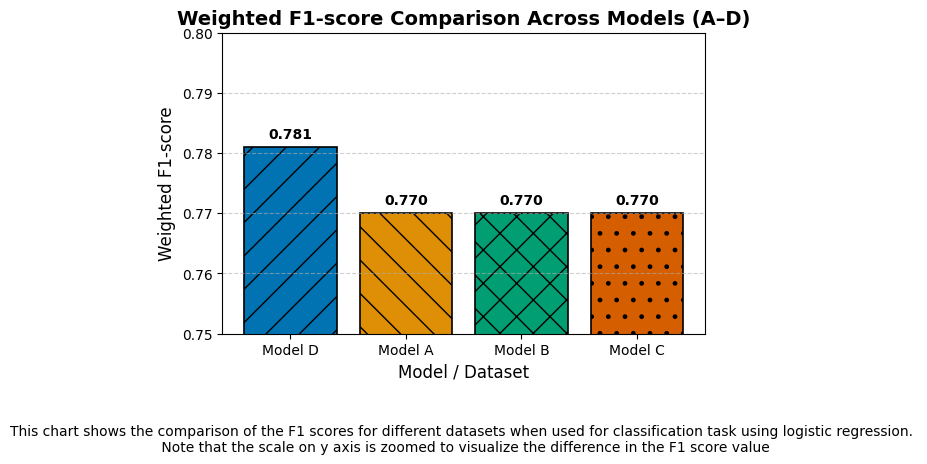

In [50]:
# Create a summary table comparing the performance metrics(especially F1-score) of the four models:

summary_data = []

for name, res in results.items():
    report = res['report_dict']
    acc = res['accuracy']

    f1_default_0 = report['0']['f1-score']
    f1_default_1 = report['1']['f1-score']
    f1_weighted = report['weighted avg']['f1-score']
    precision_weighted = report['weighted avg']['precision']
    recall_weighted = report['weighted avg']['recall']

    summary_data.append({
        'Model': f"Model {name}",
        'Accuracy': round(acc, 3),
        'F1 (Class 0)': round(f1_default_0, 3),
        'F1 (Class 1)': round(f1_default_1, 3),
        'F1 (Weighted Avg)': round(f1_weighted, 3),
        'Precision (Weighted)': round(precision_weighted, 3),
        'Recall (Weighted)': round(recall_weighted, 3)
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(by='F1 (Weighted Avg)', ascending=False).reset_index(drop=True)

print("Logistic Regression Performance Summary (Datasets A–D):")
display(summary_df)

plt.figure(figsize=(8, 5))

colors = sns.color_palette("colorblind", len(summary_df))
patterns = ['/', '\\', 'x', '.', 'O', '-', '+', '*']  # repeating hatch patterns

bars = plt.bar(
    summary_df['Model'],
    summary_df['F1 (Weighted Avg)'],
    color=colors,
    edgecolor='black',
    linewidth=1.2
)

for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)

plt.ylim(0.75, 0.80)  # adjust based on your observed range
plt.grid(axis='y', linestyle='--', alpha=0.6)

for index, row in summary_df.iterrows():
    plt.text(
        index,
        row['F1 (Weighted Avg)'] + 0.001,
        f"{row['F1 (Weighted Avg)']:.3f}",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.title("Weighted F1-score Comparison Across Models (A–D)", fontsize=14, weight='bold')
plt.ylabel("Weighted F1-score", fontsize=12)
plt.xlabel("Model / Dataset", fontsize=12)

plt.text(
    0.5, -0.3,
    "This chart shows the comparison of the F1 scores for different datasets when used for classification task using logistic regression. \n Note that the scale on y axis is zoomed to visualize the difference in the F1 score value",
    ha='center',
    va='top',
    fontsize=10,
    wrap=False,
    transform=plt.gca().transAxes
)

plt.tight_layout()
plt.show()


2. Efficacy Discussion

- Discuss the trade-off between Listwise Deletion (Model D) and Imputation (Models A, B, C). Why might Model D perform poorly even if the imputed models perform worse?

    - Even though imputation preserves more data, Listwise Deletion can sometimes appear better in overall metrics if the dropped rows include “harder” examples.
    - Weighted metrics favor the majority class, so improvements in accuracy/F1 may reflect better performance on the majority class, not minority.
    - If the goal is to predict the minority class (default = 1), all models struggle — class imbalance is the main challenge.


| Aspect            | Models A/B/C (Imputation)           | Model D (Listwise Deletion)                                     |
| ----------------- | ----------------------------------- | --------------------------------------------------------------- |
| Data Retention    | 100% of rows retained               | Only 5701 rows (dropped ~5% with missing `BILL_AMT1`)           |
| Accuracy          | 0.808                               | 0.818                                                           |
| Weighted F1       | 0.770                               | 0.781                                                           |
| Minority Class F1 | 0.356–0.357                         | 0.383                                                           |
| Bias Risk         | Slight bias due to imputation error | Potential bias due to removed rows (MAR)                        |
| Observations      | Robust, no lost data                | Slightly better metrics but less data; majority class dominates |


The comparison highlights the trade-off between imputation-based approaches (Models A, B, and C) and listwise deletion (Model D). While Models A–C retain 100% of the dataset, ensuring no loss of information, Model D discards around 5% of rows with missing values, reducing the sample size to 5,701. Despite this, Model D shows slightly higher accuracy (0.818) and weighted F1-score (0.781) compared to the imputed models (0.808 and 0.770, respectively). However, this apparent improvement may be misleading — the deletion of data can introduce bias if the missingness is not completely random, potentially distorting model generalization. The imputed models, though marginally less accurate, are more robust and representative since they preserve all available data. Overall, Model D benefits from a cleaner but smaller dataset, while Models A–C offer a more complete and stable modeling approach with minimal bias risk.

- Which regression method (Linear vs. Non-Linear) performed better and why? Relate this to the assumed relationship between the imputed feature and the predictors.

    - The linear logistic regression model (Dataset B) performs equally well as the non-linear version (Dataset C), and since there’s no accuracy or F1-score gain from non-linearity, the linear model is preferred for its simplicity and interpretability.

    - The identical performance of the linear (Model B) and non-linear (Model C) imputation approaches suggests that the relationship between the imputed feature (e.g., BILL_AMT1) and its predictors is largely linear in nature. In other words, a simple linear regression model was sufficient to capture the dependency between that feature and the others in the dataset, and introducing non-linear relationships through more complex regression did not uncover any additional structure or variance relevant to the target prediction. This implies that the missing feature’s underlying pattern aligns well with a linear trend—so using non-linear imputation neither improved feature quality nor enhanced the model’s classification ability. Therefore, the linear imputation is both theoretically appropriate and computationally more efficient, making it the more suitable choice in this context.

- Conclude with a recommendation on the best strategy for handling missing data in this scenario, justifying your answer by referencing both the classification performance metrics and the conceptual implications of each method.

    - Based on both the classification performance metrics and the conceptual understanding of the imputation methods, the best strategy for handling missing data in this scenario is to use linear regression imputation (Model B). All imputation-based models (A, B, C) retained the full dataset, ensuring no loss of valuable information, whereas listwise deletion (Model D) discarded around 5 % of the rows, potentially introducing bias due to the MAR (Missing At Random) mechanism. Although Model D showed slightly higher accuracy (0.818 vs. 0.808), this improvement is marginal and likely due to a smaller, cleaner subset dominated by the majority class, not a genuine increase in predictive capability. Between the imputed models, the linear regression approach performed just as well as the non-linear one, suggesting that the relationship between the imputed feature (e.g., BILL_AMT1) and its predictors is predominantly linear—making linear imputation both statistically sound and computationally efficient. Median imputation, while simple, ignores feature relationships and may underrepresent variance. Therefore, linear regression imputation offers the best balance between preserving data integrity, maintaining model stability, and reflecting realistic feature relationships, making it the most appropriate and conceptually robust approach for handling missing data in this credit risk prediction task.
